In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
import csv
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
def describe_dataset(dataset_path: str):
    ''''''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data
def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

#### 1 Read and describe data

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z']
Number of rows: 3650 
Number of columns: 28

Labels: 
label
U    1726
M    1170
D     754
Name: count, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: object)


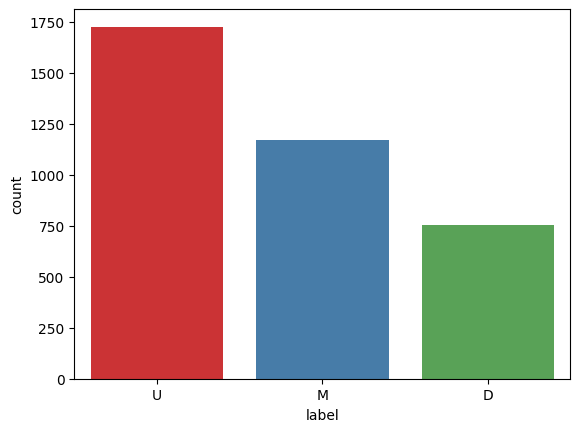

In [3]:
df = describe_dataset('train_clean_merged.csv')
sns.countplot(x='label', data=df, palette="Set1") 
df.loc[df["label"] == "D", "label"] = 0
df.loc[df["label"] == "M", "label"] = 1
df.loc[df["label"] == "U", "label"] = 2

## Phân chia dữ liệu

### Chia dữ liệu

In [6]:
X = df.drop("label", axis=1)
y = df["label"].astype("int")

In [44]:
# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

201     2
481     1
2707    1
Name: label, dtype: int32

In [45]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### Thử nghiệm các mô hình

In [46]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1, 2])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1, 2])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1, 2])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])


,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,RF,"[0.938, 0.853, 0.93]",0.909589,"[0.884, 0.841, 0.965]","[0.91, 0.847, 0.947]","[[152, 20, 0], [9, 180, 25], [1, 11, 332]]"
1,KNN,"[0.943, 0.837, 0.905]",0.894521,"[0.866, 0.794, 0.971]","[0.903, 0.815, 0.937]","[[149, 23, 0], [9, 170, 35], [0, 10, 334]]"
2,SVC,"[0.925, 0.836, 0.896]",0.886301,"[0.866, 0.762, 0.974]","[0.895, 0.797, 0.933]","[[149, 23, 0], [12, 163, 39], [0, 9, 335]]"
3,DTC,"[0.872, 0.751, 0.927]",0.860274,"[0.831, 0.79, 0.919]","[0.851, 0.77, 0.923]","[[143, 29, 0], [20, 169, 25], [1, 27, 316]]"
4,LR,"[0.888, 0.789, 0.873]",0.854795,"[0.831, 0.701, 0.962]","[0.859, 0.743, 0.916]","[[143, 27, 2], [18, 150, 46], [0, 13, 331]]"
5,SGDC,"[0.875, 0.789, 0.836]",0.834247,"[0.855, 0.612, 0.962]","[0.865, 0.689, 0.895]","[[147, 22, 3], [21, 131, 62], [0, 13, 331]]"
6,NB,"[0.774, 0.723, 0.812]",0.784932,"[0.855, 0.477, 0.942]","[0.812, 0.575, 0.872]","[[147, 19, 6], [43, 102, 69], [0, 20, 324]]"


### Dùng mô hình độ chính xác phù hợp

In [7]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
# # Lưu mô hình vào file
# with open('sklearn_RFC_squat.pkl', 'wb') as file:
#     pickle.dump(model, file)

In [9]:
# # Tải mô hình từ file
# with open('sklearn_RFC_squat.pkl', 'rb') as file:
#     model_loaded = pickle.load(file)

# # Sử dụng mô hình để dự đoán
# predictions = model_loaded.predict(X)
# predictions


In [10]:

# train_sizes, train_scores, test_scores = learning_curve(model, X, y, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

# # Tính giá trị trung bình và độ lệch chuẩn cho train và test scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Vẽ learning curves
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# plt.title("Learning Curves")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.legend(loc="best")
# plt.show()


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán và tính toán confusion matrix
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, predictions))


Confusion Matrix:
 [[153  19   0]
 [ 10 179  25]
 [  0  12 332]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       172
           1       0.85      0.84      0.84       214
           2       0.93      0.97      0.95       344

    accuracy                           0.91       730
   macro avg       0.91      0.90      0.90       730
weighted avg       0.91      0.91      0.91       730



# Chọn bộ tham số

#### Dùng GridSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

In [ ]:
best_params_grid = {}
models_tuned_grid = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ("SVC", SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("SGDC", CalibratedClassifierCV(SGDClassifier())),
    ("NB", GaussianNB()),
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    },
    "SVC": {
        "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
        "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    }
}

# Grid Search application with check for parameter grid existence
for name, model in models.items():
    print("Model processing: ", name)
    if name in param_grid:
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid[name], 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,  # Sử dụng tất cả các lõi CPU để tăng tốc quá trình
            verbose=1  # Hiển thị tiến trình trong quá trình tìm kiếm
        )
        grid_search.fit(X_train, y_train)
        best_params_grid[name] = grid_search.best_params_
        models_tuned_grid[name] = grid_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params1.json', 'w') as f:
    json.dump(best_params_grid, f)

In [ ]:
# Printing the best parameters for each model
print("Best parameters for each model:")
for name, params in best_params_grid.items():
    print(f"{name}: {params}")

# Printing the tuned models
print("\nTuned models:")
for name, model in models_tuned_grid.items():
    print(f"{name}: {model}")


#### Dùng RandomizedSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

In [8]:
best_params_random = {}
models_tuned_random = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ("SVC", SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("SGDC", CalibratedClassifierCV(SGDClassifier())),
    ("NB", GaussianNB()),
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    },
    "SVC": {
        "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
        "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in models.items():
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X_train, y_train)
        best_params_random[name] = randomized_search.best_params_
        models_tuned_random[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  LR
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model processing:  SVC
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model processing:  KNN
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model processing:  DTC
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model processing:  SGDC
No parameter grid defined for SGDC
Model processing:  NB
No parameter grid defined for NB
Model processing:  RF
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [11]:
with open('best_params_v1.json', 'w') as f:
    json.dump(best_params_random, f)

In [9]:
# Printing the best parameters for each model
print("Best parameters for each model:")
for name, params in best_params_random.items():
    print(f"{name}: {params}")

# Printing the tuned models
print("\nTuned models:")
for name, model in models_tuned_random.items():
    print(f"{name}: {model}")


Best parameters for each model:
LR: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.623776739188721}
SVC: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
KNN: {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}
DTC: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 20}
RF: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90}

Tuned models:
LR: LogisticRegression(C=1.623776739188721)
SVC: SVC(C=10, gamma='auto', probability=True)
KNN: KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')
DTC: DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=10)
RF: RandomForestClassifier(max_depth=90, n_estimators=2000)


#### Thử nghiệm bộ tham số

In [49]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(**best_params.get("SGDC", {})))),
    ("NB", GaussianNB()),  # GaussianNB không có tham số cụ thể để điều chỉnh
    ('RF', RandomForestClassifier(**best_params.get("RF", {}), random_state=42)),
]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1, 2])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1, 2])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1, 2])
    final_results.append((name, round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)

# Display results in a DataFrame for better visualization
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])


,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,SVC,"[0.917, 0.863, 0.933]",0.909589,"[0.901, 0.822, 0.968]","[0.909, 0.842, 0.95]","[[155, 17, 0], [14, 176, 24], [0, 11, 333]]"
1,RF,"[0.938, 0.848, 0.93]",0.908219,"[0.884, 0.836, 0.965]","[0.91, 0.842, 0.947]","[[152, 20, 0], [10, 179, 25], [0, 12, 332]]"
2,KNN,"[0.95, 0.861, 0.911]",0.905479,"[0.884, 0.808, 0.977]","[0.916, 0.834, 0.942]","[[152, 20, 0], [8, 173, 33], [0, 8, 336]]"
3,DTC,"[0.924, 0.804, 0.901]",0.878082,"[0.849, 0.785, 0.951]","[0.885, 0.794, 0.925]","[[146, 25, 1], [11, 168, 35], [1, 16, 327]]"
4,LR,"[0.892, 0.781, 0.869]",0.850685,"[0.814, 0.701, 0.962]","[0.851, 0.739, 0.913]","[[140, 29, 3], [17, 150, 47], [0, 13, 331]]"
5,SGDC,"[0.852, 0.77, 0.838]",0.826027,"[0.837, 0.593, 0.965]","[0.845, 0.67, 0.897]","[[144, 27, 1], [24, 127, 63], [1, 11, 332]]"
6,NB,"[0.774, 0.723, 0.812]",0.784932,"[0.855, 0.477, 0.942]","[0.812, 0.575, 0.872]","[[147, 19, 6], [43, 102, 69], [0, 20, 324]]"


In [50]:
best_model = models['SVC']
with open('best_models/SVC_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [51]:
def load_model(model_filename):
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

# Example of loading the Logistic Regression model
loaded_lr_model = load_model('best_models/SVC_model.pkl')

In [52]:
predictions = loaded_lr_model.predict(X_test)
predictions

array([1, 1, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 0,
       2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 2,
       2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 1, 2,
       1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       2, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1,
       1, 0, 0, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2,
       2, 2, 1, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 0, 2,
       1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2,
       0, 1, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 0, 2, 2,

In [53]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Optionally, add a column to check if the predictions match the actual values
comparison_df['Match'] = comparison_df['Actual'] == comparison_df['Predicted']

# Display the DataFrame
print(comparison_df)

      Actual  Predicted  Match
201        2          1  False
481        1          1   True
2707       1          1   True
822        0          0   True
25         2          2   True
...      ...        ...    ...
3368       2          2   True
1863       0          0   True
190        2          2   True
3481       2          2   True
2722       1          0  False

[730 rows x 3 columns]


In [54]:
# Calculate the percentage of matches
match_rate = comparison_df['Match'].mean() * 100
print(f"Percentage of Correct Predictions: {match_rate:.2f}%")


Percentage of Correct Predictions: 90.96%
